In [58]:
#LOADING IN LIBRARIES
import pandas as pd
import numpy as np
import scipy
from scipy import interpolate

import gpytorch
import torch
import math

import seaborn as sns

#FOR WORKING WITH DATES
from calendar import month_name as mn
import datetime
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as mdates #for working with dates in plots

#FOR PLOTTING
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tempfile
import plotly.figure_factory as ff

In [59]:
import wandb
wandb.login()

%env "WANDB_NOTEBOOK_NAME" "test.ipynb"

wandb.init( #starts new wandb run
    project = "syn_model", #saves to syn_model project
    name = "test",
    dir = tempfile.gettempdir()) 
#note had to run "git config --global --add safe.directory /D/MIT-WHOI/github_repos/syn_model" in order for this to work on jupyter notebook

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


env: "WANDB_NOTEBOOK_NAME"="test.ipynb"


In [60]:
config = wandb.config #for saving model inputs and hyperparameters



# Importing Data

In [61]:
def import_data():
    PATH = "../data/dfmerged_dailysynenv.csv"
    df = pd.read_csv(PATH)#.drop_duplicates(subset = "date") #remove duplicate days

    months = mn[1:] #importing month names from calendar

    #reformat dates to datetime format
    df.date = pd.to_datetime(df.date, format = "%Y-%m-%d")
    df.year = df.date.dt.year
    df.month = df.date.dt.month
    df["doy_numeric"] = df.date.dt.dayofyear
    df["doy"] = pd.to_datetime(df.date.dt.dayofyear, format = "%j")
    df["monthname"] = pd.Categorical(df.date.dt.month_name(), categories=months, ordered = True)
    df["year_numeric"] = df.year + df.doy_numeric/365

    df["temp"] = df.Beam_temperature_corrected
    wandb.log_artifact(PATH, name = "syn_data",type = "mvco_data")
    return df

df = import_data()
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
AvgSolar,3575.0,151.168763,95.092767,-2.800000,74.882639,135.881944,223.602778,851.388235
AvgWindDir,3575.0,196.848362,72.442314,13.912500,149.199306,208.754167,249.670139,340.055556
AvgWindSpeed,3575.0,5.047937,2.234000,0.729167,3.526389,4.668056,6.047222,25.530556
Beam_temperature_corrected,3575.0,10.836090,6.373021,-1.419508,4.727163,10.991591,16.680652,21.855795
NH4_mean,1011.0,1.242777,1.088931,0.000000,0.507853,0.949099,1.784963,8.084891
NO3_mean,1011.0,0.345125,0.677637,0.000000,0.000000,0.080211,0.353688,6.561361
PO4_mean,1011.0,0.201055,0.179226,0.000000,0.070666,0.158569,0.283627,1.632589
SiO2_mean,1011.0,3.651877,3.574976,0.000000,1.236628,2.684718,4.980182,44.106465
doy_numeric,5541.0,187.463815,100.134435,1.000000,109.000000,187.000000,272.000000,366.000000
month,5541.0,6.664140,3.274614,1.000000,4.000000,7.000000,9.000000,12.000000


In [63]:
fig = make_subplots(rows=2, cols=2,
                   subplot_titles = ("Original Distribution","Frequency of Syn Data","Log Normal Distribution","Winter and Summer Distributions"))


#################################
#PLOTTING ORIGINAL DISTRIBUTION
#################################
fig.add_trace(
    go.Histogram(x = df["synconc"], showlegend = False),
    row=1, col=1)

fig.update_xaxes(title_text="Syn Concentration", 
                 row=1, col=1)

fig.update_yaxes(title_text="Frequency", 
                 row=1, col=1)

#######################################
#PLOTTING FREQUENCY
#########################################
#CALCULATING THE FFT
fft = np.fft.rfft(df['synconc'].dropna())
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['synconc'].dropna())
days_per_year = 365.2524
years_per_dataset = n_samples_d/(days_per_year)

print( "Number of Samples: " + str(n_samples_d))
#     print(years_per_dataset)

#     print(f_per_dataset)
f_per_year = f_per_dataset/years_per_dataset

#plotting frequency
fig.add_trace(go.Scatter(x = f_per_year, y = np.abs(fft), showlegend = False),
           row=1, col=2)

fig.update_xaxes(title_text="Frequency (log scale)", 
                 type="log",
                 row=1, col=2,
                 tickvals = [1, 365.2524], 
                 ticktext = ['1/Year', '1/day'])

#######################################
#PLOTTING Log Normal Distribution
#########################################
fig.add_trace(
    go.Histogram(x = np.log(df["synconc"]),showlegend = False),
    row=2, col=1)


#######################################
#PLOTTING Winter and Summer Distributions
#########################################
# distplot
hist_data = [np.log(df[df.temp<=11]["synconc"]).dropna(), np.log(df[df.temp>=11]["synconc"]).dropna()]
group_labels = ['Winter','Summer']
fig2 = ff.create_distplot(hist_data, group_labels)


#PLOTTING HISTOGRAMS
fig.add_trace(go.Histogram(fig2['data'][0],
                           marker_color='blue',
                          name = "Winter"), 
              row=2, col=2)

fig.add_trace(go.Histogram(fig2['data'][1],
                           marker_color='red',
                          name = "Summer"), 
              row=2, col=2)


#PLOTTING DISTRIBUTIONS
fig.add_trace(
    go.Scatter(fig2['data'][2],
                         line=dict(color='blue', width=0.5),
                          name = "Winter"), 
                row=2, col=2)

fig.add_trace(
    go.Scatter(fig2['data'][3],
                         line=dict(color='red', width=0.5),
                          name = "Summer"), 
                row=2, col=2)



fig.update_layout(height=600, width=800, 
                  title_text="Syn Concentration Histogram",
                 legend=dict(
                    yanchor="bottom",
                    y=0.01,
                    xanchor="right",
                    x=1.18
                ))
fig.show()

wandb.log({"Syn Statistics": fig})

Number of Samples: 4694


In [64]:
def create_daily_df(df):
    #SETTING DAILY FREQUENCY TO DATA
    dfd = df.drop_duplicates(subset = "date").copy()

    print(dfd.shape)

    # dfindexed = dfd.groupby(pd.PeriodIndex(data = dfd.date,freq = "D"))
    dfd = dfd.set_index("date",inplace = False)
    dfd.head()

    dfd =dfd.asfreq("D")
    dfd = dfd.reset_index()

    print("shape after setting daily frequency: " + str(dfd.shape))
    dfd["lindex"] = dfd.index

    dfd["doy_numeric"] = dfd.date.dt.dayofyear
    dfd["log_syn"] = np.log(dfd.synconc)
    
    dfd["Year_sin"] = 4*np.sin(2*np.pi/365*dfd.lindex)
    dfd["Year_cos"] = 4*np.cos(2*np.pi/365*dfd.lindex)


    dfd.head()
    return dfd
    
dfd = create_daily_df(import_data())
dfd.head()


(4765, 17)
shape after setting daily frequency: (5598, 17)


,date,AvgSolar,AvgWindDir,AvgWindSpeed,Beam_temperature_corrected,NH4_mean,NO3_mean,PO4_mean,SiO2_mean,doy,...,month,monthname,synconc,year,year_numeric,temp,lindex,log_syn,Year_sin,Year_cos
0,2003-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-10,...,5.0,May,354.187094,2003.0,2003.356164,NaN,0,5.869825,0.000000,4.000000
1,2003-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-11,...,5.0,May,381.916883,2003.0,2003.358904,NaN,1,5.945203,0.068853,3.999407
2,2003-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-12,...,5.0,May,507.483356,2003.0,2003.361644,NaN,2,6.229464,0.137686,3.997630
3,2003-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-13,...,5.0,May,704.463939,2003.0,2003.364384,NaN,3,6.557437,0.206479,3.994667
4,2003-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-05-14,...,5.0,May,898.691727,2003.0,2003.367123,NaN,4,6.800940,0.275210,3.990521


# Preparing training and testing data

In [75]:
test_size = 5000

dfd["one_index"] = torch.linspace(0,1,len(dfd))
dfd_train = dfd.loc[:test_size]
dfd_test = dfd.loc[test_size:]

dfd_train = dfd_train[["one_index","Year_sin","temp","synconc"]].dropna()


#preparing training data
train_x = dfd_train[["one_index","temp"]]
train_y = dfd_train[["synconc"]]

print("training data types")
print(train_x.dtypes)
print(train_y.dtypes)

train_x = torch.tensor(np.float32(train_x.to_numpy()))
train_y = torch.tensor(np.float32(train_y.to_numpy()))
# train_x = torch.reshape(train_x,(-1,))
# train_y = torch.reshape(train_y,(-1,))

print("training data shape: ",train_x.shape,train_y.shape)


#preparing testing data
dfd_test = dfd_test[["one_index","Year_sin","temp","synconc"]].dropna()

test_x = dfd_test[["one_index"]]

test_x = torch.tensor(np.float32(test_x.to_numpy()))

print("testing data shape",test_x.shape)

training data types
one_index    float32
temp         float64
dtype: object
synconc    float64
dtype: object
training data shape:  torch.Size([2044, 2]) torch.Size([2044, 1])
testing data shape torch.Size([296, 1])


In [80]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [97]:
model.sample_from_prior()

TypeError: sample_from_prior() missing 1 required positional argument: 'prior_name'

In [77]:
#putting the model and the likelihood in training mode
model.train()
likelihood.train()

training_iter = 2

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Output from model
    output = model(train_x)
    output
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)

    loss.sum().backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.sum().item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    #updates values
    optimizer.step()

Iter 1/2 - Loss: 40126857216.000   lengthscale: 0.693   noise: 0.693
Iter 2/2 - Loss: 19402184704.000   lengthscale: 0.974   noise: 0.974


In [53]:
test_x = torch.linspace(0,1,100)

In [57]:
model.eval() #put model in evaluation mode
likelihood.eval()

f_preds = model(train_x)
y_preds = likelihood(model(test_x))


# f_mean = f_preds.mean
# f_var = f_preds.variance
# f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

RuntimeError: shape '[2044, 2044]' is invalid for input of size 2044

In [27]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

print(train_x.shape,train_y.shape)

test_x = torch.linspace(0, 1, 51)
print(test_x.shape)

torch.Size([100]) torch.Size([100])
torch.Size([51])


In [28]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [29]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()
print(train_x.shape,train_y.shape)

Iter 1/50 - Loss: 0.936   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.904   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.870   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.832   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.789   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.742   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.690   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.638   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.588   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.542   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.501   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.463   lengthscale: 0.291   noise: 0.284
Iter 13/50 - Loss: 0.427   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.392   lengthscale: 0.255   noise: 0.237
Iter 15/50 - Loss: 0.358   lengthscale: 0.242   noise: 0.216
Iter 16/50 - Loss: 0.324   lengthscale: 0.232   noise: 0.196
Iter 17/50 - Loss: 0.290   length

In [42]:
model.eval()
likelihood.eval()

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     test_x = torch.linspace(0, 1, 51)
#     observed_pred = likelihood(model(test_x))

# f_mean = f_preds.mean
# f_var = f_preds.variance
# f_covar = f_preds.covariance_matrix
# # f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

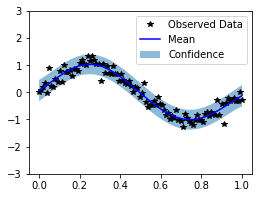